In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
# train_input = train_input + val_input
# train_output = train_output + val_output

In [21]:
# train_input = np.concatenate(train_input, axis=0)
# val_input = np.concatenate(val_input, axis=0)
# test_input = np.concatenate(test_input, axis=0)

# train_output = np.concatenate(train_output, axis=0)
# val_output = np.concatenate(val_output, axis=0)
# test_output = np.concatenate(test_output, axis=0)

In [22]:
test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

test_input = np.concatenate(test_input, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [23]:
print(test_input.shape)
print(test_output.shape)

(1000, 13953)
(1000, 1)


In [24]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [25]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [26]:
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
test_input = test_input.float()
test_output = test_output.float()

In [29]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [30]:
test_input = test_input.to(device)
test_output = test_output.to(device)

In [31]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [32]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [33]:
PATH = 'No_norm_model_RNA_pro'

In [48]:
def fit(num_epochs, model, loss_fn, RNA, pro, i):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 1999 == 0:
            model = model.eval()
            
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            cal_test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            losses[i, 0] = s1d1_loss
            losses[i, 1] = s1d2_loss
            losses[i, 2] = s1d3_loss
            losses[i, 3] = s2d1_loss
            losses[i, 4] = s2d4_loss
            losses[i, 5] = s2d5_loss
            losses[i, 6] = s3d1_loss
            losses[i, 7] = s3d6_loss
            losses[i, 8] = s3d7_loss
            losses[i, 9] = s4d1_loss
            losses[i, 10] = s4d8_loss
            losses[i, 11] = s4d9_loss
            
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss)
            
        if epoch == 1999:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

In [54]:
losses = np.zeros((12, 12))

In [55]:
RNAs = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9]
pros = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7, pro_s4d1, pro_s4d8, pro_s4d9]

Epoch  0 s1d1:  0.2800266 s1d2:  0.2707126 s1d3:  0.32644096 s2d1: 1.229051 s2d4: 0.9581218 s2d5: 0.45123148 s3d1: 0.54594564 s3d6: 0.5266852 s3d7: 0.34444058 s4d1: 0.5370504 s4d8: 0.46141508 s4d9: 1.3126192
Epoch  1999 s1d1:  0.0529527 s1d2:  0.18378298 s1d3:  0.204637 s2d1: 1.1031423 s2d4: 0.79589975 s2d5: 0.36347893 s3d1: 0.4693147 s3d6: 0.43050924 s3d7: 0.28005594 s4d1: 0.37388745 s4d8: 0.30481791 s4d9: 1.1240954


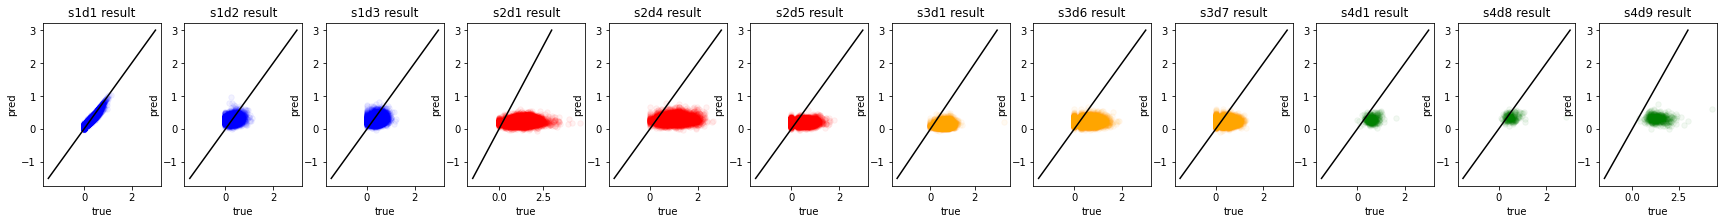

Epoch  0 s1d1:  0.27876395 s1d2:  0.25994426 s1d3:  0.3221365 s2d1: 1.2223686 s2d4: 0.95147777 s2d5: 0.4407874 s3d1: 0.5422574 s3d6: 0.51710147 s3d7: 0.33579424 s4d1: 0.5243195 s4d8: 0.44712844 s4d9: 1.2965351
Epoch  1999 s1d1:  0.19000734 s1d2:  0.04841278 s1d3:  0.20064588 s2d1: 1.0802792 s2d4: 0.7922754 s2d5: 0.3566872 s3d1: 0.446275 s3d6: 0.42069343 s3d7: 0.27577072 s4d1: 0.35647872 s4d8: 0.29789343 s4d9: 1.1157658


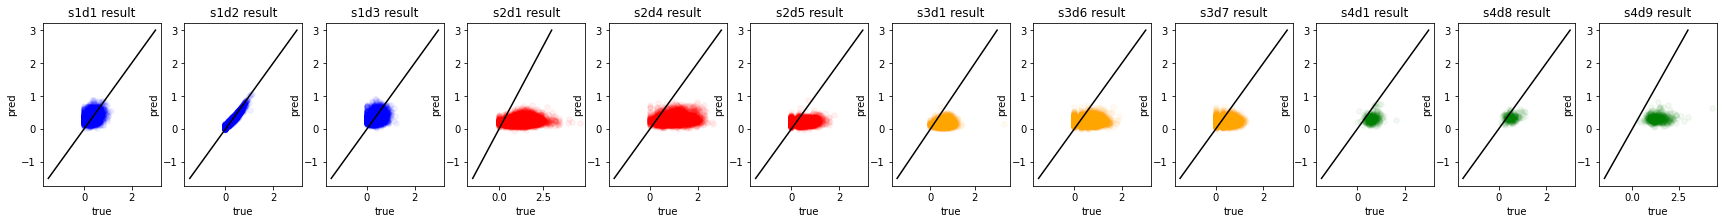

Epoch  0 s1d1:  0.26782748 s1d2:  0.25614056 s1d3:  0.30965316 s2d1: 1.2153027 s2d4: 0.9424566 s2d5: 0.43973252 s3d1: 0.5373762 s3d6: 0.5137263 s3d7: 0.33488828 s4d1: 0.51879424 s4d8: 0.44455543 s4d9: 1.2914526
Epoch  1999 s1d1:  0.19951983 s1d2:  0.19534615 s1d3:  0.072230466 s2d1: 1.0531082 s2d4: 0.74073327 s2d5: 0.3413721 s3d1: 0.42874634 s3d6: 0.39300668 s3d7: 0.26561254 s4d1: 0.31389663 s4d8: 0.26643854 s4d9: 1.0318669


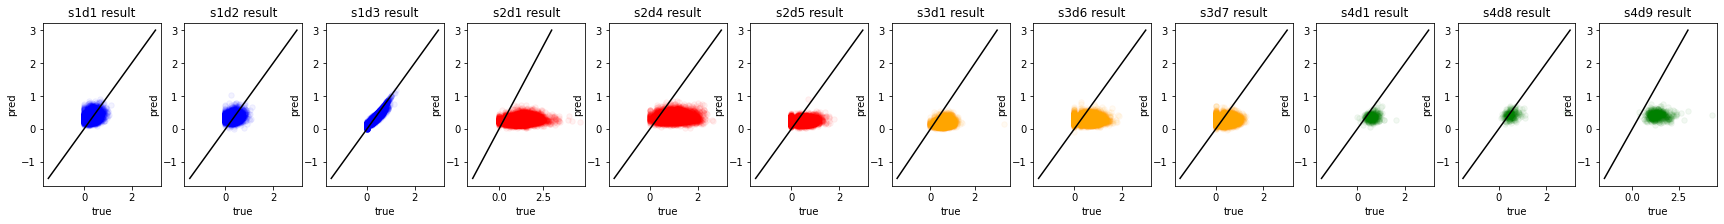

Epoch  0 s1d1:  0.20801786 s1d2:  0.20696889 s1d3:  0.20939809 s2d1: 1.0542642 s2d4: 0.75987744 s2d5: 0.32968214 s3d1: 0.4378842 s3d6: 0.382757 s3d7: 0.25816256 s4d1: 0.32329398 s4d8: 0.29041442 s4d9: 1.0602376
Epoch  1999 s1d1:  1.4888582 s1d2:  1.506083 s1d3:  1.3354646 s2d1: 0.20052972 s2d4: 0.9809887 s2d5: 0.84243184 s3d1: 0.35610843 s3d6: 0.9178643 s3d7: 1.0525575 s4d1: 1.253217 s4d8: 1.5560212 s4d9: 0.7609092


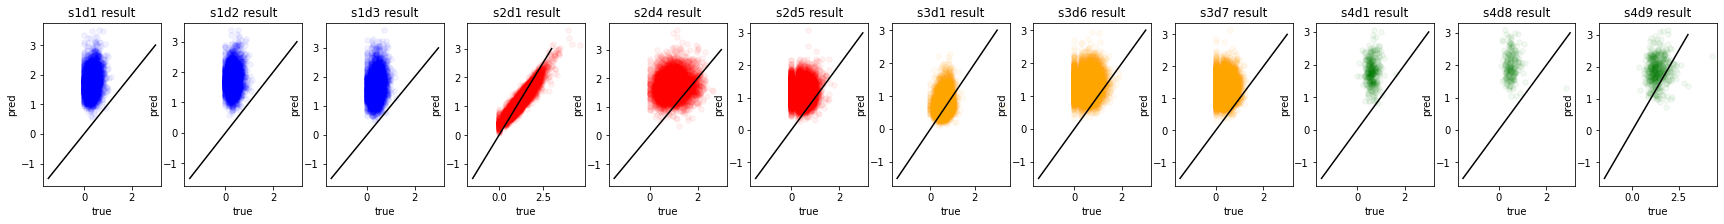

Epoch  0 s1d1:  0.20910923 s1d2:  0.2155102 s1d3:  0.20360968 s2d1: 1.0469533 s2d4: 0.7335641 s2d5: 0.32552376 s3d1: 0.43493786 s3d6: 0.37532732 s3d7: 0.2573187 s4d1: 0.301943 s4d8: 0.27958593 s4d9: 1.0368118
Epoch  1999 s1d1:  0.75784266 s1d2:  0.7284309 s1d3:  0.5844869 s2d1: 0.74578 s2d4: 0.057367098 s2d5: 0.4051599 s3d1: 0.25060102 s3d6: 0.39678115 s3d7: 0.5347703 s4d1: 0.53142387 s4d8: 0.7515336 s4d9: 0.5498611


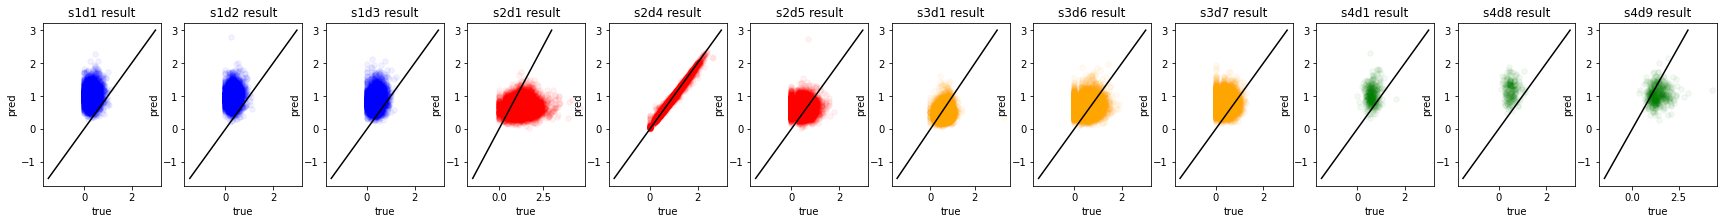

Epoch  0 s1d1:  0.30063325 s1d2:  0.28117377 s1d3:  0.34412953 s2d1: 1.2344962 s2d4: 0.97262144 s2d5: 0.44912326 s3d1: 0.5482944 s3d6: 0.5289659 s3d7: 0.34503964 s4d1: 0.54775006 s4d8: 0.4702765 s4d9: 1.321203
Epoch  1999 s1d1:  0.539634 s1d2:  0.46187773 s1d3:  0.45968437 s2d1: 0.8695042 s2d4: 0.554813 s2d5: 0.13304427 s3d1: 0.38249347 s3d6: 0.3589092 s3d7: 0.31800944 s4d1: 0.27279234 s4d8: 0.36649483 s4d9: 0.849397


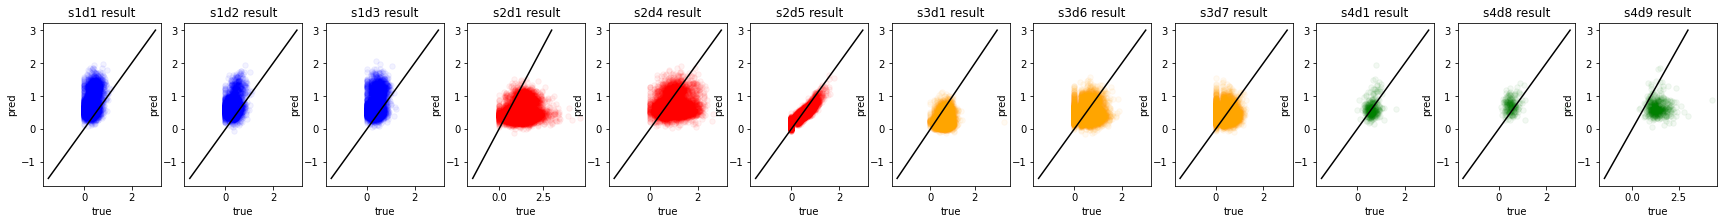

Epoch  0 s1d1:  0.32787666 s1d2:  0.31716427 s1d3:  0.37364465 s2d1: 1.2609786 s2d4: 1.0058248 s2d5: 0.476882 s3d1: 0.56212753 s3d6: 0.55704963 s3d7: 0.36981955 s4d1: 0.5887251 s4d8: 0.5122746 s4d9: 1.3669373
Epoch  1999 s1d1:  0.72456324 s1d2:  0.76489437 s1d3:  0.6651389 s2d1: 0.64095414 s2d4: 0.47204417 s2d5: 0.46451953 s3d1: 0.14842528 s3d6: 0.4842946 s3d7: 0.586933 s4d1: 0.5011664 s4d8: 0.7096889 s4d9: 0.45784098


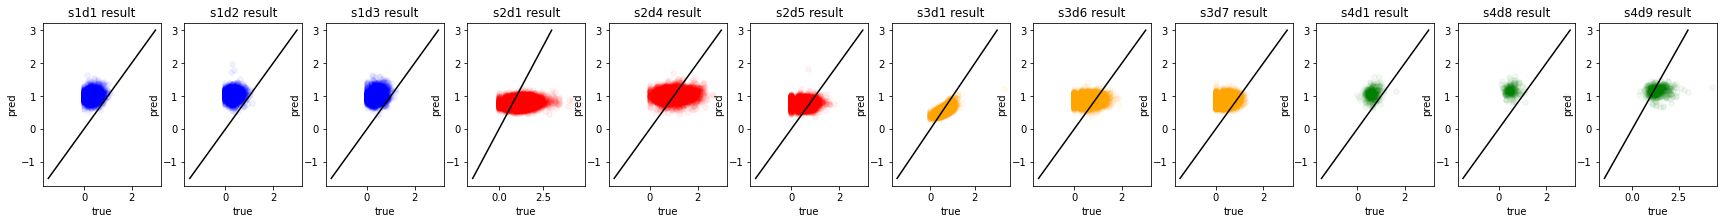

Epoch  0 s1d1:  0.26949596 s1d2:  0.25069815 s1d3:  0.31063083 s2d1: 1.2048554 s2d4: 0.9342469 s2d5: 0.42718515 s3d1: 0.5301941 s3d6: 0.5005378 s3d7: 0.3229227 s4d1: 0.5072305 s4d8: 0.43152025 s4d9: 1.2761759
Epoch  1999 s1d1:  0.41853142 s1d2:  0.42075968 s1d3:  0.36690983 s2d1: 0.86487097 s2d4: 0.55681795 s2d5: 0.33339703 s3d1: 0.30866957 s3d6: 0.15076126 s3d7: 0.3442527 s4d1: 0.25226262 s4d8: 0.3770657 s4d9: 0.7904599


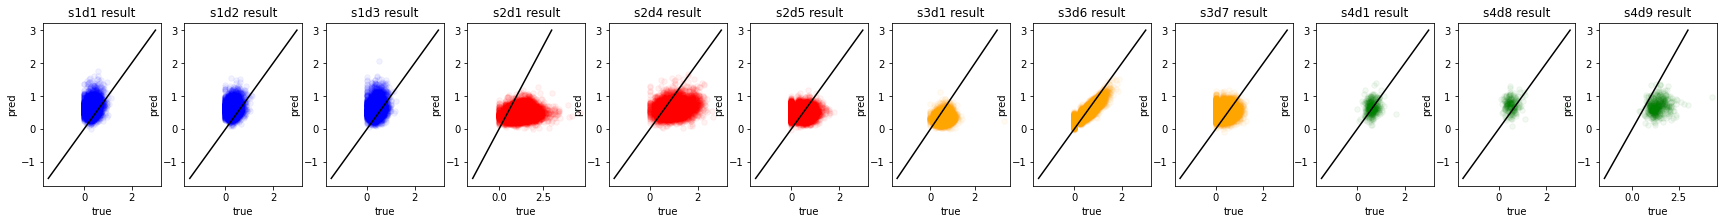

Epoch  0 s1d1:  0.3176621 s1d2:  0.30169696 s1d3:  0.36413172 s2d1: 1.2525783 s2d4: 0.99218607 s2d5: 0.46600214 s3d1: 0.5588317 s3d6: 0.5457543 s3d7: 0.35699847 s4d1: 0.5724862 s4d8: 0.49378 s4d9: 1.3494595
Epoch  1999 s1d1:  0.24319333 s1d2:  0.25517368 s1d3:  0.22769763 s2d1: 1.0417627 s2d4: 0.7341541 s2d5: 0.33023027 s3d1: 0.41603777 s3d6: 0.37200367 s3d7: 0.13846336 s4d1: 0.31674471 s4d8: 0.27824193 s4d9: 1.0071813


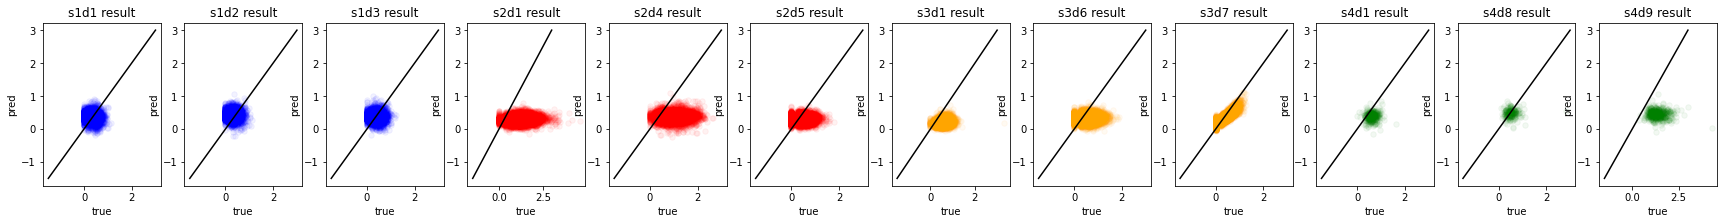

Epoch  0 s1d1:  0.21414313 s1d2:  0.19931987 s1d3:  0.24240258 s2d1: 1.1371225 s2d4: 0.84660304 s2d5: 0.37627295 s3d1: 0.4907414 s3d6: 0.44119358 s3d7: 0.28162354 s4d1: 0.40413606 s4d8: 0.3427622 s4d9: 1.1629236
Epoch  1999 s1d1:  0.33543015 s1d2:  0.3343794 s1d3:  0.2836517 s2d1: 0.90330637 s2d4: 0.5748662 s2d5: 0.29501313 s3d1: 0.32072246 s3d6: 0.3150754 s3d7: 0.2771633 s4d1: 0.0041705417 s4d8: 0.28616613 s4d9: 0.8197004


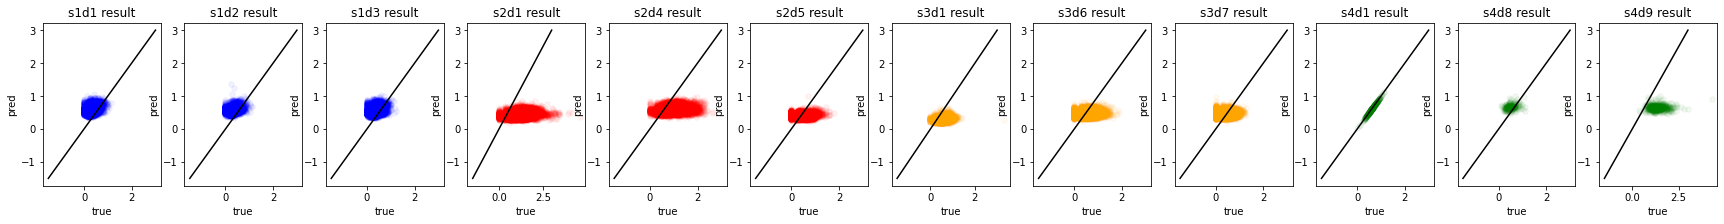

Epoch  0 s1d1:  0.22529896 s1d2:  0.20666707 s1d3:  0.257314 s2d1: 1.1528926 s2d4: 0.8649886 s2d5: 0.38608423 s3d1: 0.50098723 s3d6: 0.45311445 s3d7: 0.2884717 s4d1: 0.42461374 s4d8: 0.35304716 s4d9: 1.1823552
Epoch  1999 s1d1:  0.28293413 s1d2:  0.25128764 s1d3:  0.2592411 s2d1: 0.9689296 s2d4: 0.63842547 s2d5: 0.30727583 s3d1: 0.36827934 s3d6: 0.34391814 s3d7: 0.2532009 s4d1: 0.2352597 s4d8: 0.00385541 s4d9: 0.92611736


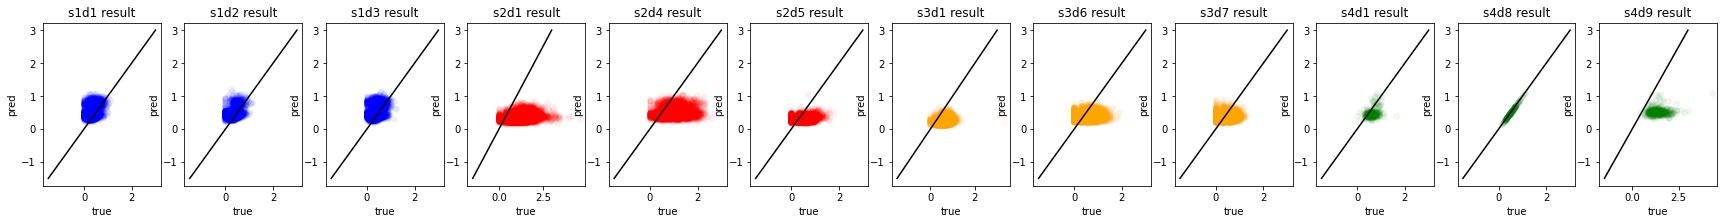

Epoch  0 s1d1:  0.39176598 s1d2:  0.4361139 s1d3:  0.34427065 s2d1: 0.8917168 s2d4: 0.5873527 s2d5: 0.3102574 s3d1: 0.348097 s3d6: 0.32488862 s3d7: 0.32398668 s4d1: 0.23938675 s4d8: 0.37091514 s4d9: 0.76773936
Epoch  1999 s1d1:  0.9019979 s1d2:  0.92117184 s1d3:  0.8783702 s2d1: 0.5618559 s2d4: 0.5160075 s2d5: 0.6398387 s3d1: 0.24407227 s3d6: 0.6011384 s3d7: 0.6808801 s4d1: 0.7032612 s4d8: 0.8749105 s4d9: 0.0047426876


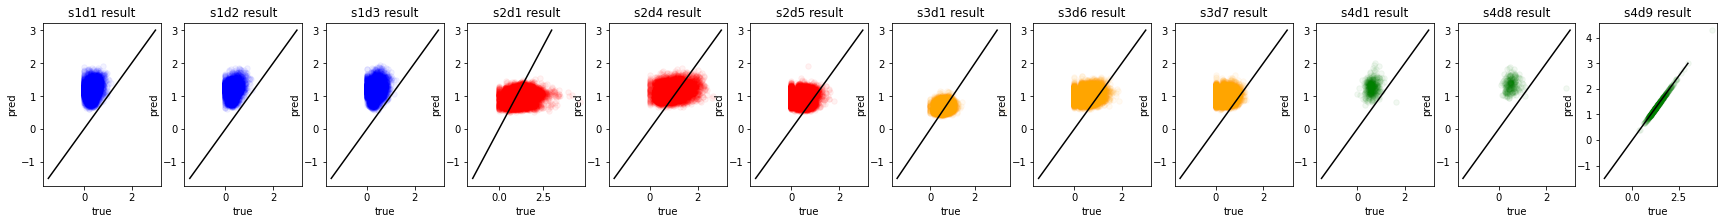

In [56]:
for i in range(12):
    
    num_epochs = 2000
    learning_rate = 0.001
    latent_dim = 50
    loss_fn = F.mse_loss
    batch_size = 50000

    def seed_everything(seed=1234):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    seed_everything()

    model = Autoencoder()
    # model.load_state_dict(torch.load('Batch_feature_norm_model'))
    model = model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    fit(num_epochs, model, loss_fn, RNAs[i], pros[i], i)

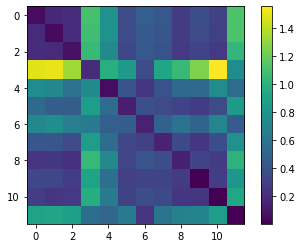

In [57]:
plt.imshow(losses)
plt.colorbar()
plt.show()